# Section 02: Classification I

<a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode.txt"><img alt="Attribution-NonCommercial-ShareAlike 4.0 International" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-nc-sa.eu.svg" title="This work is licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International Public License"/></a>


## Contents

- [Introduction](#introduction)
- [Install and Import Required Packages](#installation)
- [Creating a Training Dataset](#training-dataset)
    - [Simulation](#simulation)
        - [Task 1](#task1)
    - [Labelling Training Data](#labelling)
        - [Task 2](#task2)
        - [Task 3](#task3)
    - [Calculating Input Features](#features)
        - [Task 4](#task4)
- [Creating a Logistic Regression Model](#modelling)
    - [Training](#training)
    - [Test](#test)
        - [Prediction](#prediction)
        - [Evaluation](#evaluation)
    - [Task 5: Comprehensive Application](#task5)
- [Summary](#summary)


<a name="introduction"></a>
## Introduction

In this section, we begin to train our machine learning models with **supervised learning**, which is a novel paradigm for population genetic problems ([Schrider and Kern 2018](https://doi.org/10.1016/j.tig.2017.12.005)). Usually, there are two primary questions that can be addressed using supervised learning.
1. **Classification**: Categorizing data into predefined classes, ideal for tasks where the output is a discrete label.
2. **Regression**: Dealing with continuous quantities, suitable for tasks like forecasting numerical values.

Classification and regression problems are commonly encountered in population genetics. For instance, the detection of genome segments originating from introgression can be approached as a classification problem. This is because each genome segment can be categorized as either belonging to the 'introgression' class or the 'non-introgression' class. Conversely, estimating the proportion of introgression within a genome can be treated as a regression problem since this proportion represents a continuous quantity.

[Introgression](https://en.wikipedia.org/wiki/Introgression) refers to the transfer of genetic material from one lineage to another between two deeply divergent populations or species. This process is illustrated in the figure below:

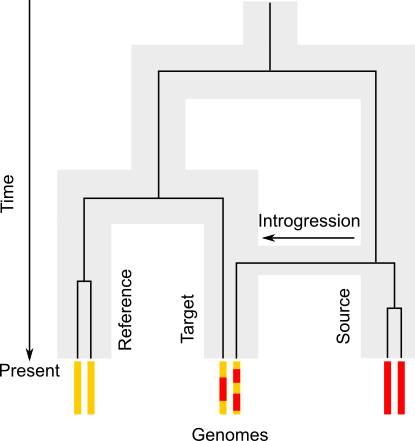

Due to [genetic recombination](https://en.wikipedia.org/wiki/Genetic_recombination) events, which can break and recombine genomic sequences, the genomes in the recipient population may contain segments derived from the donor population. These segments are referred to as introgressed fragments. In this context, the 'reference population' is defined as the population without introgressed fragments, the 'target population' is the one that receives introgressed fragments, and the 'source population' is the one donating these fragments to the target population.

Here, we will utilize [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) to detect ghost introgressed fragments in genomes. The term 'ghost' refers to introgressed fragments originating from source populations with no known genome sequences. Although the term 'regression' appears in logistic regression, it is typically applied to binary classification problems that only contain two possible outcomes. This is because logistic regression involves two key components:
1. Establishing a linear combination $Z$ of the input feature $X=(X_1, X_2, \dots, X_n)$: $Z=\beta_0+\beta_1X_1+\beta_2X_2+\dots+\beta_nX_n$, where $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ are parameters estimated in logistic regression.
2. Converting $Z$ to a probability $Pr(Y=1|X)$ by the logistic function: $Pr(Y=1|X)=\sigma(Z)=1/(1+e^{-Z})$.

This model outputs a probability that $Y$ belongs to one of the two classes, for example, '0' (representing the non-introgression class) and '1' (denoting the introgression class), making it suitable for binary classification. A decision threshold, often set at 0.5, is then used to categorize this probability into binary outcomes. The term 'regression' in logistic regression is derived from its linear regression approach to modeling the [log-odds](https://en.wikipedia.org/wiki/Logit):

$$\text{logit}[Pr(Y=1|X)]=\ln\left[\frac{Pr(Y=1|X)}{1-Pr(Y=1|X)}\right]=\beta_0+\beta_1X_1+\beta_2X_2+\dots+\beta_nX_n$$

but its application is distinctly suited to classification problems.

The logistic function is well-known for its characteristic S-shape, as shown below:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

z = np.linspace(5, -5, 100)
plt.xlabel('$Z$')
plt.ylabel('$Pr(Y=1|X)$')
plt.plot(z, 1/(1+np.exp(-z)), 'r-', lw=5, alpha=0.6)
plt.show()

<a name="installation"></a>
## Install and Import Required Packages

In [ ]:
# Install required packages
!pip install demes demesdraw msprime pyranges scikit-allel scikit-learn tskit
!wget -c https://raw.githubusercontent.com/xin-huang/pgml/main/Section_02/utils.py

# Import required packages
import allel, demes, demesdraw, msprime, os, pickle, scipy, tskit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyranges as pr
from scipy.spatial import distance_matrix
from sklearn.linear_model import LogisticRegression

<a name="training-dataset"></a>
## Creating a Training Dataset

<a name="simulation"></a>
### Simulation

To obtain a good machine learning model, we first need to collect enough training data. Fortunately, we can use simulation to create a training dataset in this tutorial. Here, we will use [msprime](https://tskit.dev/msprime/docs/stable/intro.html) \([Baumdicker et al. 2022](https://doi.org/10.1093/genetics/iyab229)\) to simulate data with a demographic model from [Durvasula and Sankararaman (2019)](https://doi.org/10.1371/journal.pgen.1008175), which is a simplified demographic model for the [Neanderthal](https://en.wikipedia.org/wiki/Neanderthal) introgression to modern humans. We have converted the demographic model into the [Demes](https://popsim-consortium.github.io/demes-docs/latest/introduction.html) format ([Gower et al. 2022](https://doi.org/10.1093/genetics/iyac131)). The demographic model is shown below:

In [ ]:
# https://github.com/sriramlab/ArchIE/blob/master/simulations/ms.sh#L7C48-L7C179
archie_3D19 = """
doi:
    - https://doi.org/10.1371/journal.pgen.1008175
time_units: generations
demes:
    - name: ancestral
      epochs:
          - {end_time: 2500, start_size: 10000}
    - name: source
      ancestors: [ancestral]
      start_time: 12000
      epochs:
          - {end_time: 6120, start_size: 10000}
          - {end_time: 6000, start_size: 100}
          - {end_time: 0, start_size: 10000}
    - name: reference
      ancestors: [ancestral]
      epochs:
          - {end_time: 0, start_size: 10000}
    - name: target
      ancestors: [ancestral]
      epochs:
          - {end_time: 0, start_size: 10000}
pulses:
    - {sources: [source], dest: target, time: 2000, proportions: [0.02]}
"""

We can visualize this demographic model with the following codes:

In [ ]:
demesdraw.tubes(demes.loads(archie_3D19))

In this demographic model, the target population is the population that receives gene flow (the dash arrow) from the source population, whereas the reference population is the population does not contain genetic materials from the source population. We have implemented a function `simulate_data()` below to simulate genomes from a specified demographic model.

In [ ]:
def simulate_data(demog: str, nref: int, ntgt: int, ref_id: str, tgt_id: str,
                  seq_len: int, mut_rate: float, rec_rate: float, ploidy: int,
                  output_dir: str, output_prefix: str, seed: int = None) -> None:
    """
    Description:
        Simulates sequence data with a given demographic model by msprime.

    Arguments:
        demog str: String of the demographic model in the Demes format.
        nref int: Number of individuals sampled from the reference population.
        ntgt int: Number of individuals sampled from the target population.
        ref_id str: Name of the reference population in the demographic model.
        tgt_id str: Name of the target population in the demographic model.
        seq_len int: Length of the simulated sequence.
        mut_rate float: Mutation rate per base pair per generation.
        rec_rate float: Recombination rate per base pair per generation.
        ploidy int: Ploidy of the simulated genome.
        output_dir str: Name of the output directory.
        output_prefix str: Prefix of the output file name.
        seed int: Random seed.

    Returns:
        None.
    """
    demography = msprime.Demography.from_demes(demes.loads(demog))
    samples = [
        msprime.SampleSet(nref, ploidy=ploidy, population=ref_id),
        msprime.SampleSet(ntgt, ploidy=ploidy, population=tgt_id),
    ]

    ts = msprime.sim_ancestry(
        recombination_rate=rec_rate,
        sequence_length=seq_len,
        samples=samples,
        demography=demography,
        record_migrations=True,
        random_seed=seed,
    )
    ts = msprime.sim_mutations(ts, rate=mut_rate, random_seed=seed,
                               model=msprime.BinaryMutationModel())

    os.makedirs(output_dir, exist_ok=True)
    ts_file = f'{output_dir}/{output_prefix}.ts'
    vcf_file = f'{output_dir}/{output_prefix}.vcf'
    ref_ind_file = f'{output_dir}/{output_prefix}.ref.ind.list'
    tgt_ind_file = f'{output_dir}/{output_prefix}.tgt.ind.list'

    ts.dump(ts_file)
    with open(vcf_file, 'w') as o: ts.write_vcf(o)

    with open(ref_ind_file, 'w') as f:
        for i in range(nref):
            f.write(f'tsk_{i}\n')

    with open(tgt_ind_file, 'w') as f:
        for i in range(i+1, nref + ntgt):
            f.write(f'tsk_{i}\n')

<a name="simulation-example"></a>
Here is an example demonstrating how to use the `simulate_data()` function. We simulate data using the above demographic model `archie_3D19`, sampling 50 diploid individuals from the reference population and another 50 diploid individuals from the target population. The mutation rate is set at 1.25e-8 per base pair per generation, and the recombination rate at 1e-8 per base pair per generation. We limit the simulation to a sequence of 50,000 base pairs (bp) in length, because we will divide a longer genome into segments of 50 kbp and determine whether a given segment represents an introgressed fragment. We also specify a seed `555` for the random number generator to ensure we can get the same result.

In [ ]:
simulate_data(demog=archie_3D19, nref=50, ntgt=50, ref_id='reference',
              tgt_id='target', seq_len=50000, mut_rate=1.25e-8, rec_rate=1e-8,
              ploidy=2, output_dir='examples', output_prefix='example.training',
              seed=555)

After simulation, we can find a [tree-sequence](https://tskit.dev/tutorials/what_is.html) file `example.training.ts` and a [VCF](https://samtools.github.io/hts-specs/VCFv4.2.pdf) file `example.training.vcf` in the `example` folder using the following shell command:

In [ ]:
!ls -l examples

Tree-sequence is an efficient way to store genetic data ([Kelleher et al. 2019](https://doi.org/10.1038/s41588-019-0483-y)). The tree-sequence file `example.training.ts` records a lot of information from the simulation, for example, the introgressed fragments. However, since this file is in a binary format, it is not human-readable. To address this, we create an additional file, `example.training.vcf`, which contains the simulated genomes in a format that can be easily read by humans. Now we can examine the first 10 lines in `example.training.vcf` with the following shell command:

In [ ]:
!head -10 examples/example.training.vcf

Besides, two files `example.training.ref.ind.list` and `example.training.tgt.ind.list` specify the individuals from the reference and target populations, respectively. For example, we can find the first five individuals from the reference population using the following command:

In [ ]:
!head -5 examples/example.training.ref.ind.list

<a name="task1"></a>
**Task 1:** Please use the `simulate_data()` function with the same parameter settings from the above example to create a training dataset with 100 replicates. However, modify `output_dir='examples'` to `output_dir='training'` and change `output_prefix='example.training'` to `output_prefix='lr.training'`. Then we can create a training dataset with suffcient amount of simulated data.

In [ ]:
# Please implement your code here.


<details>
  <summary>
    <font size="3" color="darkgreen">
      <b>Click for hints</b>
    </font>
  </summary>

  1. To simulate data across 100 replicates, implement a for-loop using `for i in range(100):`. This loop should encapsulate the following command from the previous [example](#simulation-example):
  
    ```
    simulate_data(demog=archie_3D19, nref=50, ntgt=50, ref_id='reference',
                   tgt_id='target', seq_len=50000, mut_rate=1.25e-8, rec_rate=1e-8,
                   ploidy=2, output_dir='examples', output_prefix='example.training',
                   seed=555)
    ```
  2. Modify the `output_dir` parameter from `output_dir='examples'` to `output_dir='training'` to direct the output to the correct directory.
  3. It is essential to modify the `output_prefix` parameter for each replicate to prevent overwriting. Use the [Python f-string feature](https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/) for this: `output_prefix=f'lr.training.{i}'`. The `f` before the quotation marks denotes a formatted string, allowing you to embed expressions, like `{i}`, inside the string. These expressions are evaluated at runtime, which means the value of `i` is dynamically inserted into the string, as `i` varies with each iteration. So, for each iteration, you get a unique output prefix like `lr.training.0`, `lr.training.1`, and so on, ensuring each file is distinct.
  4. Remove the `seed` parameter. If you use the same seed for all simulations, you will end up with identical data in each replicate. This is not good for training machine learning models because these models learn better from a variety of different examples. If a model only sees the same data over and over, it will not learn effectively. By not setting a `seed`, each simulation creates different data, giving the model a wider range of examples to learn from. This helps the model to understand and predict new, unseen data more accurately in the future.

  - <details>
      <summary>
        <font size="3" color="darkblue">
          <b>Click for solutions</b>
        </font>
      </summary>

    ```
    for i in range(100):
        simulate_data(demog=archie_3D19, nref=50, ntgt=50, ref_id='reference',
                      tgt_id='target', seq_len=50000, mut_rate=1.25e-8, rec_rate=1e-8,
                      ploidy=2, output_dir='training', output_prefix=f'lr.training.{i}')
    ```
  </details>
</details>

We can examine the first ten files in the `training` folder using the following shell command:

In [ ]:
!ls -l training | head -10

<a name="labelling"></a>
### Labelling Training Data

For supervised learning, it is necessary to supply the ground truth to the machine learning model. In our tutorial, we need to inform the model about which fragments are introgressed and which are not. This necessity underlines why we use simulation to create the training dataset: it allows us to determine the ground truth regarding introgressed fragments within the simulated data. Below, we have developed the function `get_true_tracts()` to extract the true introgressed fragments from a given tree-sequence file.


In [ ]:
def get_true_tracts(ts_file: str, tgt_id: str, src_id: str, ploidy: int,
                    bed_file: str) -> None:
    """
    Description:
        Obtains true introgressed tracts at the haploid level
        from a given tree-sequence file.

    Arguments:
        ts_file str: Name of the tree-sequence file.
        tgt_id str: Name of the target population.
        src_id str: Name of the source population.
        ploidy int: Ploidy of the genomes.
        bed_file str: Name of the output file storing the true introgressed
                      tract in the BED format.

    Returns:
        None.
    """
    tracts = pd.DataFrame(columns=['Chromosome', 'Start', 'End', 'Sample'])

    ts = tskit.load(ts_file)
    src_id = [p.id for p in ts.populations() if p.metadata['name']==src_id][0]
    tgt_id = [p.id for p in ts.populations() if p.metadata['name']==tgt_id][0]

    for m in ts.migrations():
        if (m.dest==src_id) and (m.source==tgt_id):
            for t in ts.trees():
                if m.left >= t.interval.right: continue
                if m.right <= t.interval.left: break
                for n in ts.samples(tgt_id):
                    if t.is_descendant(n, m.node):
                        if m.left > t.interval.left:
                            left = m.left
                        else:
                            left = t.interval.left
                        if m.right < t.interval.right:
                            right = m.right
                        else:
                            right = t.interval.right
                        tracts.loc[len(tracts.index)] = [
                            1, int(left), int(right),
                            f'tsk_{ts.node(n).individual}_{int(n%ploidy+1)}'
                        ]

    open(bed_file, 'w').close()
    for s in tracts['Sample'].unique():
        sample_tracts = tracts[tracts['Sample'] == s].copy()

        sample_tracts = pr.PyRanges(sample_tracts)
        merged_sample_tracts = sample_tracts.merge(strand=False)
        sample_names = pd.Series(
            data=[s]*len(merged_sample_tracts), name="Sample")
        merged_sample_tracts = merged_sample_tracts.insert(sample_names)

        with open(bed_file, 'a') as f:
            f.write(merged_sample_tracts.df.to_csv(
                    sep="\t", header=False, index=False))

<a name="true-tract-example"></a>
We can obtain the true introgressed fragments in the tree-squence file `lr.training.ts` with the following codes:

In [ ]:
get_true_tracts(ts_file='examples/example.training.ts',
                tgt_id='target', src_id='source', ploidy=2,
                bed_file='examples/example.training.true.tracts.bed')

The true introgressed fragments are stored in the file `lr.training.true.tracts.bed`, which is in the [BED](https://genome.ucsc.edu/FAQ/FAQformat.html#format1) format. We can view this file with the following shell command:

In [ ]:
!cat examples/example.training.true.tracts.bed

The first column is the name of the simulated chromosome. The second column is the start position of an introgressed fragment in the genome, and the third column is the end position of an introgressed fragment in the genome. The fourth column is the name of the sample containing an introgressed fragment. For example, as shown above, the first haplotype of the individual `tsk_64` has an introgressed fragment ranging from the position 0 to the position 50,000, while the second haplotype of the individual `tsk_73` has an introgressed fragment starting at the position 0 and ending at the position 16,319.


<a name="task2"></a>
**Task 2:** Please use the `get_true_tracts()` function to extract all the true introgressed fragments in the simulated dataset from [Task 1](#task1).

In [ ]:
# Please implement your code here.


<details>
  <summary>
    <font size="3" color="darkgreen">
      <b>Click for hints</b>
    </font>
  </summary>

  1. Again, implement a for-loop using `for i in range(100):` to wrap the following command from the above [example](#true-tract-example):
  
    ```
    get_true_tracts(ts_file='examples/example.training.ts',
                     tgt_id='target', src_id='source', ploidy=2,
                     bed_file='examples/example.training.true.tracts.bed')
    ```
  2. Use Python f-string to modify the `ts_file` parameter from `ts_file='examples/example.training.ts'` to `ts_file=f'training/lr.training.{i}.ts'`, because our simulated data from [Task 1](#task1) are stored in the `training` folder with the prefix `lr.training.{i}`.
  3. Also, change the `bed_file='examples/example.training.true.tracts.bed'` to `bed_file=f'training/lr.training.{i}.true.tracts.bed` to direct the output to the correct directory.

  - <details>
      <summary>
        <font size="3" color="darkblue">
          <b>Click for solutions</b>
        </font>
      </summary>

    ```
    for i in range(100):
        get_true_tracts(ts_file=f'training/lr.training.{i}.ts',
                        tgt_id='target', src_id='source', ploidy=2,
                        bed_file=f'training/lr.training.{i}.true.tracts.bed')
    ```
  </details>
</details>

After obtaining the true introgressed fragments, we can label each simulated sequence as introgressed or non-introgressed based on these true introgressed fragments. Because machine learning models make predictions using category numbers, such as 0, 1, and 2, in classification problems, we will label a sequence as introgressed with 1, and a sequence as non-introgressed with 0. We have implemented a function `label_data()` below to label our simulated data according to a specified BED file containing the true introgressed fragments.

In [ ]:
def label_data(true_tract_file: str, nref: int, ntgt: int, seq_len: int,
               ploidy: int, intro_prop: float, not_intro_prop: float,
               output: str) -> None:
    """
    Description:
        Labels each simulated genome with the true introgressed fragments.

    Arguments:
        true_tract_file str: Name of the BED file containing
                             the true introgressed fragments.
        nref int: Number of individuals sampled from the reference population.
        ntgt int: Number of individuals sampled from the target population.
        seq_len int: Length of the simulated sequence.
        ploidy int: Ploidy of the simulated genome.
        intro_prop float: Proportion that determines a fragment as introgressed.
        not_intro_prop float: Proportion that determinse a fragment as
                              non-introgressed.
        output str: Name of the output file.

    Returns:
        None.
    """
    def _add_label(row, intro_prop, not_intro_prop):
        if row['prop'] > intro_prop: return 1.0
        elif row['prop'] < not_intro_prop: return 0.0
        else: return -1.0

    label_df = pd.DataFrame(columns=['chrom', 'start', 'end', 'sample'])
    for i in range(nref, nref+ntgt):
        for p in range(ploidy):
            label_df.loc[len(label_df.index)] = [
                1, 0, seq_len, f'tsk_{i}_{p+1}'
            ]

    try:
        true_tract_df = pd.read_csv(true_tract_file, sep="\t", header=None)
    except pd.errors.EmptyDataError:
        label_df['label'] = 0.0
    else:
        true_tract_df.columns = ['chrom', 'start', 'end', 'sample']
        true_tract_df['len'] = true_tract_df['end'] - true_tract_df['start']
        true_tract_df = true_tract_df.groupby(
            by=['sample']
        )['len'].sum().reset_index()
        true_tract_df['prop'] = true_tract_df['len'] / seq_len
        true_tract_df['label'] = true_tract_df.apply(
            lambda row: _add_label(row, intro_prop, not_intro_prop), axis=1)
        label_df = label_df.merge(true_tract_df.drop(columns=['len', 'prop']),
                                  left_on=['sample'], right_on=['sample'],
                                  how='left').fillna(0)
    finally:
        label_df['label'] = label_df['label'].astype('int8')
        label_df.to_csv(output, sep="\t", index=False)

<a name="label-example"></a>
Now we can label our simulated data using the `label_data()` function and the true introgressed fragments in `lr.training.true.tracts.bed`.

In [ ]:
label_data(true_tract_file='examples/example.training.true.tracts.bed',
           nref=50, ntgt=50, seq_len=50000, ploidy=2,
           intro_prop=0.7, not_intro_prop=0.3,
           output='examples/example.training.labels')

We can examine the labels of the first 50 samples with the following shell command:

In [ ]:
!head -51 examples/example.training.labels

To classify these samples, we employ two parameters in the `labelling_data()` function: `intro_prop` and `not_intro_prop`. These parameters help determine the labels based on the proportion of the length of the introgressed fragment to the total length of the simulated sequence. Besides the classes `0` and `1`, we introduce an additional class `-1` to account for variations in the length of introgressed fragments across different simulated genomes:

- A sample is labeled as `1` if the proportion is larger than `intro_prop`.
- A sample is labeled as `0` if the proportion is less than `not_intro_prop`.
- A sample is labeled as `-1` if the proportion falls between `intro_prop` and `not_intro_prop`.

For example, the introgressed fragment in `tsk_64_1` is 50,000 bp long, identical to the length of the simulated sequence, resulting in a proportion of 1. This exceeds the threshold of `intro_prop=0.7`, thus `tsk_64_1` is labeled as `1`. Conversely, `tsk_73_2` has an introgressed fragment measuring 16,319 bp in a 50,000 bp sequence, yielding a proportion of approximately 0.32658. This value lies between `intro_prop=0.7` and `not_intro_prop=0.3`, so `tsk_73_2` is labeled as `-1`.
We will discard those data with the class `-1` later, because logistic regression is best suited for binary classification.

<a name="task3"></a>
**Task 3:** Please use the `label_data()` function to label the simulated data from [Task 1](#task1).

In [ ]:
# Please implement your code here.


<details>
  <summary>
    <font size="3" color="darkgreen">
      <b>Click for hints</b>
    </font>
  </summary>

  1. Use a for-loop and the command from [above](#label-example):
  
    ```
    label_data(true_tract_file='examples/example.training.true.tracts.bed',
                nref=50, ntgt=50, seq_len=50000, ploidy=2,
                intro_prop=0.7, not_intro_prop=0.3,
                output='examples/example.training.labels')
    ```
  2. Use Python f-string to change the `true_tract_file` parameter to those BED files created in [Task 2](#task2) and the `output` parameter to direct the output files to the `training` folder with the prefix `lr.training.{i}`.

  - <details>
      <summary>
        <font size="3" color="darkblue">
          <b>Click for solutions</b>
        </font>
      </summary>

    ```
    for i in range(100):
        label_data(true_tract_file=f'training/lr.training.{i}.true.tracts.bed',
                   nref=50, ntgt=50, seq_len=50000, ploidy=2,
                   intro_prop=0.7, not_intro_prop=0.3,
                   output=f'training/lr.training.{i}.labels')
    ```
  </details>
</details>

### Calculating Input Features

To effectively utilize logistic regression for identifying introgressed fragments, it is crucial to convert the genotypes in simulated genomes into quantitative statistics or features. For this purpose, below we have provided two functions: `cal_dist()` and `cal_mut_num()`, each serving a distinct role in calculating input features:

1. Function `cal_dist()`: This function is designed to compute the pairwise [Euclidean distances](https://en.wikipedia.org/wiki/Euclidean_distance) between genotype matrices. Its primary use is to estimate the distances in two scenarios:
    - Between genomes sampled from the reference population and those from the target population.
    - Within the genomes belonging to the target population.

  These distance measurements are crucial for assessing genetic similarities and differences, aiding in the detection of introgressed fragments.

2. Function `cal_mut_num()`: This function focuses on the enumeration of mutations, distinguishing between two types:
    - Private Mutations: These are exclusive mutations found only in the target population. Their identification is important for understanding unique genetic variations, especially for those mutations originated from the source population.
    - Total Mutations: This category includes all mutations observed in either the target or the reference population. Counting total mutations provides a comprehensive view of the genetic variability across populations.

Both functions are instrumental in transforming raw genetic data into analyzable metrics, which are then utilized in logistic regression models to detect introgressed fragments.

In [ ]:
def cal_dist(gt1: np.ndarray, gt2: np.ndarray) -> np.ndarray:
    """
    Description:
        Calculates pairswise Euclidean distances between two genotype matrices.

    Arguments:
        gt1 numpy.ndarray: Genotype matrix 1.
        gt2 numpy.ndarray: Genotype matrix 2.

    Returns:
        dists numpy.ndarray: Distances estimated.
    """
    dists = distance_matrix(np.transpose(gt2), np.transpose(gt1))
    dists.sort()

    return dists


def cal_mut_num(ref_gt: np.ndarray, tgt_gt: np.ndarray,
                mut_type: str) -> np.ndarray:
    """
    Description:
        Calculates number of private or total mutations in a sample.

    Arguments:
        ref_gt numpy.ndarray: Genotype matrix from the reference population.
        tgt_gt numpy.ndarray: Genotype matrix from the target population.
        mut_type str: Type of mutations. Private or total.

    Returns:
        mut_num numpy.ndarray: Numbers of mutations.
    """
    counts = np.sum(ref_gt, axis=1)
    counts = np.reshape(counts, (counts.shape[0],1))

    if mut_type == 'private':
        mut_num = np.sum((tgt_gt>0)*(counts==0), axis=0)
    if mut_type == 'total':
        mut_num = np.sum((tgt_gt>0), axis=0) + np.sum((tgt_gt==0)*(counts>0),
                                                       axis=0)

    return mut_num


def cal_features(ref_gts: np.ndarray, tgt_gts: np.ndarray,
                     pos: np.ndarray) -> dict:
    """
    Description:
        Calculates feature vectors from genotype matrixes.

    Arguments:
        ref_gts numpy.ndarray: Genotype matrix from the reference
                                   population.
        tgt_gts numpy.ndarray: Genotype matrix from the target population.
        pos numpy.ndarray: Positions of variants.

    Returns:
        res dict: Estimated input feature vectors.
    """
    variants_not_in_ref = np.sum(ref_gts, axis=1) == 0
    sub_ref_gts = ref_gts[variants_not_in_ref]
    sub_tgt_gts = tgt_gts[variants_not_in_ref]
    sub_pos = pos[variants_not_in_ref]

    ref_dists = cal_dist(ref_gts, tgt_gts)
    tgt_dists = cal_dist(tgt_gts, tgt_gts)

    res = dict()
    res['ttl_mut_nums'] = cal_mut_num(ref_gts, tgt_gts, mut_type='total')
    res['pvt_mut_nums'] = cal_mut_num(sub_ref_gts, sub_tgt_gts,
                                      mut_type='private')

    res['ref_dists'] = ref_dists
    res['min_ref_dists'] = np.min(ref_dists, axis=1)
    res['max_ref_dists'] = np.max(ref_dists, axis=1)
    res['mean_ref_dists'] = np.mean(ref_dists, axis=1)
    res['median_ref_dists'] = np.median(ref_dists, axis=1)
    res['var_ref_dists'] = np.var(ref_dists, axis=1)
    res['skew_ref_dists'] = scipy.stats.skew(ref_dists, axis=1)
    res['skew_ref_dists'][np.isnan(res['skew_ref_dists'])] = 0
    res['kurtosis_ref_dists'] = scipy.stats.kurtosis(ref_dists, axis=1)
    res['kurtosis_ref_dists'][np.isnan(res['kurtosis_ref_dists'])] = 0

    res['tgt_dists'] = tgt_dists
    res['min_tgt_dists'] = np.min(tgt_dists, axis=1)
    res['max_tgt_dists'] = np.max(tgt_dists, axis=1)
    res['mean_tgt_dists'] = np.mean(tgt_dists, axis=1)
    res['median_tgt_dists'] = np.median(tgt_dists, axis=1)
    res['var_tgt_dists'] = np.var(tgt_dists, axis=1)
    res['skew_tgt_dists'] = scipy.stats.skew(tgt_dists, axis=1)
    res['skew_tgt_dists'][np.isnan(res['skew_tgt_dists'])] = 0
    res['kurtosis_tgt_dists'] = scipy.stats.kurtosis(tgt_dists, axis=1)
    res['kurtosis_tgt_dists'][np.isnan(res['kurtosis_tgt_dists'])] = 0

    return res

We also implemented several helper functions below to convert the genotype data from our simulation into several features estimated with the above two functions.

In [ ]:
from utils import *
def preprocess(vcf_file: str, ref_ind_file: str, tgt_ind_file: str,
               ploidy: int, output_dir: str, output_prefix: str,
               win_len: int, win_step: int) -> None:
    """
    Description:
        Processes genotype data.

    Arguments:
        vcf_file str: Name of the VCF file containing genotype data.
        ref_ind_file str: Name of the file containing sample information
                          from the reference population.
        tgt_ind_file str: Name of the file containing sample information
                          from the target population.
        ploidy int: Ploidy of genomes.
        output_dir str: Directory storing the output files.
        output_prefix str: Prefix of the output files.
        win_len int: Length of sliding windows.
        win_step int: Step size of sliding windows.

    Returns:
        None.
    """
    ref_data, ref_samples, tgt_data, tgt_samples = read_data(
        vcf_file, ref_ind_file, tgt_ind_file
    )

    for c in tgt_data.keys():
        windows = create_windows(tgt_data[c]['POS'], c, win_step, win_len)

    res = []
    for w in windows:
        chr_name, start, end = w
        ref_gts = ref_data[chr_name]['GT']
        tgt_gts = tgt_data[chr_name]['GT']
        pos = tgt_data[chr_name]['POS']
        idx = (pos>start)*(pos<=end)
        sub_ref_gts = ref_gts[idx]
        sub_tgt_gts = tgt_gts[idx]
        sub_pos = pos[idx]
        res.append([chr_name, start, end, cal_features(
            sub_ref_gts, sub_tgt_gts, sub_pos
        )])

    output(res=res, tgt_samples=tgt_samples, ploidy=2,
           output_dir=output_dir, output_prefix=output_prefix)

<a name="preprocess-example"></a>
We then can apply the `preprocess()` function to process our simulated data in the `example` folder, as shown below:

In [ ]:
preprocess(vcf_file='examples/example.training.vcf',
           ref_ind_file='examples/example.training.ref.ind.list',
           tgt_ind_file='examples/example.training.tgt.ind.list',
           ploidy=2, output_dir='examples',
           output_prefix='example.training', win_len=50000, win_step=50000)

After processing our simulated genotype data, we can examine the features of the first ten samples. Each row contains statistics or features related to a specific haplotype. This row can be referred to as the feature vector, with its elements representing individual features.

In [ ]:
!head -11 examples/example.training.features

**Task 4:** Please use the `preprocess()` function to calculate features for the simulated data from [Task 1](#task1).

In [ ]:
# Please implement your code here.


<details>
  <summary>
    <font size="3" color="darkgreen">
      <b>Click for hints</b>
    </font>
  </summary>

  1. Use a for-loop and follow [the above command](#preprocess-example):
  
    ```
    preprocess(vcf_file='examples/example.training.vcf',
                ref_ind_file='examples/example.training.ref.ind.list',
                tgt_ind_file='examples/example.training.tgt.ind.list',
                ploidy=2, output_dir='examples',
                output_prefix='example.training', win_len=50000, win_step=50000)
    ```
  2. Alter the `vcf_file`, `ref_ind_file`, `tgt_ind_file` parameters with those corresponding files created in [Task 1](#task1).
  3. Adjust the `output_dir` and `output_prefix` parameters: the output directory is the `training` folder, and the output prefix is `lr.training.{i}`
  - <details>
      <summary>
        <font size="3" color="darkblue">
          <b>Click for solutions</b>
        </font>
      </summary>

    ```
    for i in range(100):
        preprocess(vcf_file=f'training/lr.training.{i}.vcf',
                    ref_ind_file=f'training/lr.training.{i}.ref.ind.list',
                    tgt_ind_file=f'training/lr.training.{i}.tgt.ind.list',
                    ploidy=2, output_dir='training',
                    output_prefix=f'lr.training.{i}', win_len=50000, win_step=50000)
    ```
  </details>
</details>

After transforming all the simulated data into feature vectors, we can merge these vectors with their respective labels. This combination creates the training dataset `lr.training.all.labelled.features` in the `training` folder, which is essential for developing our logistic regression model aimed at identifying ghost introgressed fragments.

In [ ]:
!head -1 training/lr.training.0.features | \
    awk '{print $0"\tlabel"}'> training/lr.training.all.labelled.features
!for ((i=0;i<100;i++)) do \
    paste <(sed '1d' training/lr.training.$i.features) \
          <(sed '1d' training/lr.training.$i.labels | awk '{print $NF}') \
          >> training/lr.training.all.labelled.features; \
 done
!head -11 training/lr.training.all.labelled.features

In the training dataset `lr.training.all.labelled.features`, along with various features, we append a label to the end of each feature vector. This label indicates whether a sample is an introgressed fragment. We can analyze the distribution of feature vectors across the different classes:

In [ ]:
!awk '$NF==0' training/lr.training.all.labelled.features | \
 awk 'END{print "Number of feature vectors belonging to class 0: "NR}'
!awk '$NF==1' training/lr.training.all.labelled.features | \
 awk 'END{print "Number of feature vectors belonging to class 1: "NR}'
!awk '$NF==-1' training/lr.training.all.labelled.features | \
 awk 'END{print "Number of feature vectors belonging to class -1: "NR}'

<a name="modelling"></a>
## Creating a Logistic Regression Model

<a name="training"></a>
### Training

Now we are ready to train our first machine learning model with our training dataset `lr.training.all.labelled.features`. Here, we will use the [Logistic Regression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from [scikit-learn](https://scikit-learn.org/stable/index.html), which is a popular Python package for machine learning.

In [ ]:
def train(feature_file: str, model_file: str) -> None:
    """
    Description:
        Function for training of the sklearn logistic classification.

    Arguments:
        feature_file str: Filename of the feature file for training.
        model_file str: Filename of the output model.

    Returns:
        None.
    """
    feature_df = pd.read_csv(feature_file, sep="\t")

    model = LogisticRegression(solver="newton-cg", penalty=None, max_iter=10000)
    # Remove feature vectors with label -1
    feature_df = feature_df[feature_df['label'] != -1]
    labels = feature_df['label']
    data = feature_df.drop(
        columns=['chrom', 'start', 'end', 'sample', 'label']).values

    model.fit(data, labels.astype(int))

    os.makedirs(os.path.dirname(model_file), exist_ok=True)
    pickle.dump(model, open(model_file, "wb"))

We provide the training dataset, `lr.training.all.labelled.features`, from Task 4 to the `train()` function and store the resulting model `logistic.regression.model` in the `models` folder:

In [ ]:
train(feature_file='training/lr.training.all.labelled.features',
      model_file='models/logistic.regression.model')

Note that we exclude those feature vectors labelled as `-1` in the `train()` function. This exclusion is due to the fact that we are applying logistic regression for binary classification, focusing solely on predicting classes `0` and `1`. We can check our model file with the following:

In [ ]:
!ls -l models

<a name="test"></a>
### Test

<a name="prediction"></a>
#### Prediction

Once we obtain our machine learning model, we can apply it for making predictions with new data. First, we need to download some test data, which should be different from the training data:

In [ ]:
!mkdir test
!wget -c https://huggingface.co/datasets/xin-huang/pgml/resolve/dev/Section_02/sim.test.features
!wget -c https://huggingface.co/datasets/xin-huang/pgml/resolve/dev/Section_02/sim.test.true.tracts.bed
!mv sim.test.features test
!mv sim.test.true.tracts.bed test

We downloaded two files in the `test` folder:

In [ ]:
!ls -l ./test

The `sim.test.features` file contains feature vectors for use in predictions, while the `sim.test.true.tracts.bed` file holds the ground truth data for introgressed fragments. This data will be utilized later to evaluate the performance of our model.

In [ ]:
def infer(feature_file: str, model_file: str, output: str) -> None:
    """
    Description:
        Function for inference using the sklearn logistic classifciation.

    Arguments:
        feature_file str: Filename of the feature file for inference.
        model_file str: Filename of the trained logistic regression model.
        prediction_file str: Filename of the output predictions.

    Returns:
        None.
    """
    with open(model_file, 'rb') as f:
        model = pickle.load(f)

    feature_df = pd.read_csv(feature_file, sep="\t")
    data = feature_df.drop(columns=['chrom', 'start', 'end', 'sample']).values

    predictions = model.predict_proba(data)

    classes = model.classes_
    columns = ['chrom', 'start', 'end', 'sample']
    for i in range(len(classes)):
        feature_df[f'class_{classes[i]}_prob'] = predictions[:,i]
        columns.append(f'class_{classes[i]}_prob')

    feature_df = feature_df[columns]
    feature_df.sort_values(
        by=['sample', 'chrom', 'start', 'end']
    ).to_csv(output, sep="\t", index=False)

Now we can predict the label of each feature vectors in the `sim.test.features` file with the model we have trained:

In [ ]:
infer(feature_file='test/sim.test.features',
      model_file='models/logistic.regression.model',
      output='test/sim.test.predictions')

We can examine our predictions for the first ten fragments:

In [ ]:
!head -11 test/sim.test.predictions

For each fragment, we predict two probabilities: one is the probability of the fragment belonging to class `0` (or not introgressed), and the other is the probability of the fragment belonging to class `1` (or introgressed).

To determine whether a fragment belongs to class `0` or `1`, we need to provide a cutoff. If the probability of the fragment belonging to class `1` exceeds this cutoff, then we assign it as an introgressed fragment. Otherwise, we consider it as a non-introgressed fragment. For this purpose, we have implemented the following fucntion:

In [ ]:
def get_inferred_tracts(prediction_file: str, cutoff: float,
                        output: str) -> None:
    """
    Description:
        Obtains inferred introgressed fragments from predictions.

    Arguments:
        prediction_file str: Name of the file containing predictions from
                             a model.
        cutoff float: Probability threshold to determine whether a fragment
                      is introgressed or not.
        output str: Name of the output file storing the inferred introgressed
                    fragments.

    Returns:
        None.
    """
    prediction_df = pd.read_csv(prediction_file, sep="\t")
    inferred_tracts = prediction_df[prediction_df['class_1_prob'] > cutoff]
    inferred_tracts_wo_probs = inferred_tracts.drop(
        columns=['class_0_prob', 'class_1_prob']
    )
    inferred_tracts_wo_probs.rename(
        columns={'chrom': 'Chromosome', 'start': 'Start',
                 'end': 'End', 'sample': 'Sample'},
    inplace=True)
    inferred_tracts = pr.PyRanges(inferred_tracts_wo_probs).merge(by='Sample')
    inferred_tracts.to_csv(output, sep="\t", header=False)

Given the `cutoff=0.9`, we can obtain the inferred introgressed fragments from our predictions:

In [ ]:
get_inferred_tracts(prediction_file='test/sim.test.predictions', cutoff=0.9,
                    output=f'test/sim.test.cutoff0.9.inferred.tracts.bed')

We can view the first ten inferred introgressed fragments:

In [ ]:
!head -10 test/sim.test.cutoff0.9.inferred.tracts.bed

<a name="evaluation"></a>
#### Evaluation



With the true framgents in `sim.test.true.tracts.bed` and inferred fragments, we can quantify how good our model is. Here, we will use two metrics — **precsion** and **recall** — to measure the performance of our model:

$$
\begin{align}
Precsion &= \frac{TP}{TP+FP} \\
Recall &= \frac{TP}{TP+FN} \\
\end{align}
$$

where

- TP: Number of True Positive instances.
- FP: Number of False Positive instances.
- FN: Number of False Negative instances.

More specifically, we define the True Positive, False Positive, and False Negative as shown in the following figure:

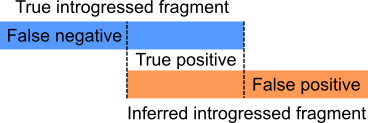

Here, we compare the inferred introgressed fragment to the true introgressed fragment. We use the length of their overlap as the True Positive ($TP$) measurement. Consequently, the total length of the inferred introgressed fragments corresponds to the sum of True Positives and False Positives ($TP + FP$). Similarly, the total length of the true introgressed fragments is the sum of True Positives and False Negatives ($TP + FN$). Therefore,

$$
\begin{align}
Precsion &= \frac{\text{Length of the overlap}}{\text{Length of the inferred introgressed fragment}} \\
Recall &= \frac{\text{Length of the overlap}}{\text{Length of the true introgressed fragment}} \\
\end{align}
$$

In simpler terms, **precision** indicates the proportion of inferred introgressed fragments that are actually true. On the other hand, **recall** measures the extent to which true introgressed fragments are correctly identified within the entire dataset ([Huang et al. 2024](https://doi.org/10.1038/s41576-023-00636-3)).

In [ ]:
def cal_pr(ntrue_tracts: int, ninferred_tracts: int,
           ntrue_positives: int) -> tuple[float, float]:
    """
    Description:
        Calculates precision and recall.

    Arguments:
        ntrue_tracts int: Length of true introgressed fragments.
        ninferred_tracts int: Length of inferred introgressed fragments.
        ntrue_positives int: Length of fragments belonging to true positives.

    Returns:
        precision float: Estimated precision.
        recall float: Estimated recall.
    """
    if float(ninferred_tracts) == 0: precision = np.nan
    else: precision = ntrue_positives / float(ninferred_tracts) * 100
    if float(ntrue_tracts) == 0: recall = np.nan
    else: recall = ntrue_positives / float(ntrue_tracts) * 100

    return precision, recall

We have implemented the `evaluate()` function below to estimate the precision and recall from the true fragment file and the inferred fragment file.

In [ ]:
def evaluate(true_tract_file: str, inferred_tract_file: str, cutoff: float,
             output: str) -> None:
    """
    Description:
        Evaluates model performance with precision and recall.

    Arguments:
        true_tract_file str: Name of the file containing true fragments.
        inferred_tract_file str: Name of the file containing inferred fragments
        cutoff float: Probability threshold to determine whether a fragment
                      is introgressed or not.
        output str: Name of the output file storing the model performance.

    Returns:
        None.
    """
    try:
        true_tracts = pd.read_csv(
            true_tract_file, sep="\t", header=None,
            names=['Chromosome', 'Start', 'End', 'Sample']
        )
    except pd.errors.EmptyDataError:
        true_tracts_samples = []
    else:
        true_tracts_samples = true_tracts['Sample'].unique()
        true_tracts = pr.PyRanges(true_tracts).merge(by='Sample')

    try:
        inferred_tracts = pd.read_csv(
            inferred_tract_file, sep="\t", header=None,
            names=['Chromosome', 'Start', 'End', 'Sample']
        )
    except pd.errors.EmptyDataError:
        inferred_tracts_samples = []
    else:
        inferred_tracts_samples = inferred_tracts['Sample'].unique()
        inferred_tracts = pr.PyRanges(inferred_tracts).merge(by='Sample')

    res = pd.DataFrame(columns=[
        'Sample', 'Cutoff', 'Precision', 'Recall', 'True_tracts_length',
        'Inferred_tracts_length', 'Overlapped_length'])

    sum_ntrue_tracts = 0
    sum_ninferred_tracts = 0
    sum_ntrue_positives = 0

    for s in np.intersect1d(true_tracts_samples, inferred_tracts_samples):
        ind_true_tracts = true_tracts[
            true_tracts.Sample == s
        ].merge(by='Sample')
        ind_inferred_tracts = inferred_tracts[
            inferred_tracts.Sample == s
        ].merge(by='Sample')
        ind_overlaps = ind_true_tracts.intersect(ind_inferred_tracts)

        ntrue_tracts = np.sum([
            x[1].End - x[1].Start for x in ind_true_tracts
        ])
        ninferred_tracts = np.sum([
            x[1].End - x[1].Start for x in ind_inferred_tracts
        ])
        ntrue_positives = np.sum([
            x[1].End - x[1].Start for x in ind_overlaps
        ])

        precision, recall = cal_pr(
            ntrue_tracts, ninferred_tracts, ntrue_positives
        )
        sum_ntrue_tracts += ntrue_tracts
        sum_ninferred_tracts += ninferred_tracts
        sum_ntrue_positives += ntrue_positives

    for s in np.setdiff1d(true_tracts_samples, inferred_tracts_samples):
        # ninferred_tracts = 0
        ind_true_tracts = true_tracts[true_tracts.Sample == s]

        ntrue_tracts = np.sum(
            [x[1].End - x[1].Start for x in ind_true_tracts]
        )
        sum_ntrue_tracts += ntrue_tracts

    for s in np.setdiff1d(inferred_tracts_samples, true_tracts_samples):
        # ntrue_tracts = 0
        ind_inferred_tracts = inferred_tracts[inferred_tracts.Sample == s]

        ninferred_tracts = np.sum(
            [x[1].End - x[1].Start for x in ind_inferred_tracts]
        )
        sum_ninferred_tracts += ninferred_tracts

    res = res.sort_values(by=['Sample'])

    total_precision, total_recall = cal_pr(
        sum_ntrue_tracts, sum_ninferred_tracts, sum_ntrue_positives
    )
    res.loc[len(res.index)] = [
        'All', cutoff, total_precision, total_recall, sum_ntrue_tracts,
        sum_ninferred_tracts, sum_ntrue_positives
    ]

    res.fillna('NaN').to_csv(output, sep="\t", index=False)

For example, we can quantify the performance of our model with a cutoff of 0.9:

In [ ]:
evaluate(true_tract_file='test/sim.test.true.tracts.bed',
         inferred_tract_file='test/sim.test.cutoff0.9.inferred.tracts.bed',
         cutoff=0.9, output='test/sim.test.cutoff0.9.performance')

Here is our model performance when `cutoff=0.9`:

In [ ]:
!cat test/sim.test.cutoff0.9.performance

<a name="evaluation-example"></a>
Now we can evaluate our model with a range of different cutoff values:

In [ ]:
cutoffs = [0, .01, .02, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .99, .999]
for c in cutoffs:
    get_inferred_tracts(prediction_file='test/sim.test.predictions', cutoff=c,
                        output=f'test/sim.test.cutoff{c}.inferred.tracts.bed')
    evaluate(true_tract_file='test/sim.test.true.tracts.bed', cutoff=c,
             inferred_tract_file=f'test/sim.test.cutoff{c}.inferred.tracts.bed',
             output=f'test/sim.test.cutoff{c}.performance')

<a name="concat-performance"></a>
Then we can merge the performances from different cutoffs into a table:

In [ ]:
!cat test/*.performance | grep -v Cutoff | awk '{print $2"\t"$3"\t"$4}' | \
 sort -nk 1,1 | sed '1iCutoff\tPrecision\tRecall' > test/performance.summary
!cat test/performance.summary

<a name="plot"></a>
Finally, we can visualize the above table as a [precision-recall curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) with the following `plot()` function.

In [ ]:
def plot(summary_file: str) -> None:
    """
    Description:
        Plots the precision-recall curve.

    Arguments:
        summary_file str: Name of the file storing the performance of a model.

    Returns:
        None.
    """
    df = pd.read_csv(summary_file, sep="\t")
    plt.plot(df['Recall'], df['Precision'], marker='o', label='PR curve')
    plt.plot([0,100],[2,2], label='baseline', linestyle='dashed')
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.title('Performance')
    plt.xlabel('Recall (%)')
    plt.ylabel('Precision (%)')
    plt.legend()
    plt.show()

The figure below illustrates a precision-recall curve plot where the x-axis represents recall, and the y-axis denotes precision. Each dot on the curve corresponds to a pair of precision and recall values at different cutoff points. The dashed line represents the baseline, indicative of the performance of a random classifier. In this tutorial, a random classifier arbitrarily labels a fragment as introgressed or non-introgressed with a given probability. Therefore, the precision of the baseline classifier is set to match the true proportion of introgressed fragments in our data. By comparing the precision-recall curve of our model to this baseline, we can directly assess its effectiveness. Essentially, a well-performing model should surpass the random classifier.

In [ ]:
plot(summary_file='test/performance.summary')

<a name="task5"></a>
### Task 5: Comprehensive Application

Please follow the instructions and complete the task:
1. Create a folder named `final_task`. Use this folder to store the results of the steps below.
2. Download the training dataset from https://huggingface.co/datasets/xin-huang/pgml/resolve/dev/Section_02/sim.training.labeled.features and then move the downloaded file to the `final_task` folder.
3. Train a logistic regression model with the downloaded training data. You can use any necessary Python functions and shell commands from above.
4. Evaluate your model performance using the test data `sim.test.features` in the `test` folder, by plotting a precision-recall curve across a range of decision cutoffs: `[0, .01, .02, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .99, .999]`.

In [ ]:
# Please implement your code here.


<details>
  <summary>
    <font size="3" color="darkgreen">
      <b>Click for hints</b>
    </font>
  </summary>

  1. **Create the `final_task` folder:** Use the [mkdir](https://linux.die.net/man/1/mkdir) command to create a folder named `final_task`. Remember to prepend `!` to `mkdir` when running it in Jupyter Notebook cells, as shell commands require `!` in this environment.

  2. **Download training data:** Follow the provided [example](#wget-example) to download the training data using the [wget](https://linux.die.net/man/1/wget) command. Then, use the [mv](https://linux.die.net/man/1/mv) command to move the downloaded file into the `final_task` folder.

  3. **Train logistic regression model:** Utilize the `train()` function (see the [training](#training) section) to train a logistic regression model using the file `sim.training.labeled.features` in the `final_task` folder. Ensure the model file is saved within the `final_task` folder.

  4. **Evaluate model and plot precision-recall curve:** Use the `infer()` function (see the [test](#test) section) for making predictions with the `sim.test.features file` located in the `test` folder. Save these predictions in the `final_task` folder. Then, apply the `get_inferred_tracts()` and `evaluate()` functions as shown in this evaluation [example](#evaluation-example) to assess the model performance at different cutoff levels. Use the following command to compile all performance metrics into a single table in the `final_task` folder:
  ```
  !cat final_task/*.performance | grep -v Cutoff | awk '{print $2"\t"$3"\t"$4}' | \
  sort -nk 1,1 | sed '1iCutoff\tPrecision\tRecall' > final_task/performance.summary
  ```
  Finally, generate a precision-recall curve using the plot function from [above](#plot).

  - <details>
      <summary>
        <font size="3" color="darkblue">
          <b>Click for solutions</b>
        </font>
      </summary>

    ```
    # Step 1
    !mkdir final_task

    # Step 2
    !wget -c https://huggingface.co/datasets/xin-huang/pgml/resolve/dev/Section_02/sim.training.labeled.features
    !mv sim.training.labeled.features final_task

    # Step 3
    train(feature_file='final_task/sim.training.labeled.features',
          model_file='final_task/logistic.regression.model')

    # Step 4
    infer(feature_file='test/sim.test.features',
          model_file='final_task/logistic.regression.model',
          output='final_task/sim.test.predictions')

    cutoffs = [0, .01, .02, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .99, .999]
    for c in cutoffs:
        get_inferred_tracts(prediction_file='final_task/sim.test.predictions', cutoff=c,
                            output=f'final_task/sim.test.cutoff{c}.inferred.tracts.bed')
        evaluate(truth_tract_file='test/sim.test.truth.tracts.bed', cutoff=c,
                 inferred_tract_file=f'final_task/sim.test.cutoff{c}.inferred.tracts.bed',
                 output=f'final_task/sim.test.cutoff{c}.performance')

    !cat final_task/*.performance | grep -v Cutoff | awk '{print $2"\t"$3"\t"$4}' | \
    sort -nk 1,1 | sed '1iCutoff\tPrecision\tRecall' > final_task/performance.summary

    plot(summary_file='final_task/performance.summary')
    ```
  </details>
</details>

<a name="summary"></a>
## Summary

In this section, we covered:
1. The fundamental workflow of **supervised learning**.
2. The process of training a **logistic regression** model to predict ghost introgressed fragments in genomes, approaching it as a **binary classification** problem.
3. The evaluation of our model performance using two key metrics: **precision** and **recall**.